In [533]:
import glob
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn import preprocessing
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from random import randint
import joblib


In [534]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [535]:
import os
from dotenv import load_dotenv
load_dotenv()
print(os.getenv('ROOT'))

import sys
sys.path.append(os.getenv('ROOT')+'/chess_board/preprocess.py')
sys.path.append(os.getenv('ROOT')+'/chess_board/inference.py')
sys.path.append(os.getenv('ROOT')+'/models/')


/Users/meghas/EPITA/S3/ImageAndVideoProcessing/EXAM/Chess_position


# **Step 1: Reading dataset**

In [536]:

train = glob.glob("data/train/*.jpeg")
test = glob.glob("data/test/*.jpeg")
val = glob.glob("data/val/*.jpeg")

print("Train size:",len(train))
print("Test size:",len(test))
print("Val size:",len(val))


Train size: 500
Test size: 200
Val size: 100


## Methods used in the notebook

In [537]:
def fen_label_extraction(data):
    """
This method take dataset as parameter and create labels for all items
    :param data: list of images in FEN format
    :return: labels contain labels for each 64 images in 8X8 chess board
    """
    labels = []
    for img in data:
        base = os.path.basename(img)
        labels.append(os.path.splitext(base)[0])
    return labels

def getX(data):
    """
This method take dataset as parameter and return list of images
    :param data: list of images in FEN format
    :return: list of images in Pixel format
    """
    X = [cv2.imread(i) for i in data]
    return X

def split_chess_board(board):
    """
This method takes a chess board image as input and generate 64 images (8X8 chess board = 64 sub images)
    :param board: Image of chess board
    :return: 64 images reshaped into 25X25X3 shape
    """
    temp = []
    for x in range(0,8):
        temp2 = board[(x*25):((x+1)*25),:]
        for y in range(0,8):
            temp.append(temp2[:,(y*25):((y+1)*25)].flatten().reshape(25,25,3))
    return temp

def split_labels(y):
    """
This split the image name in FEN format into labels for 64 images
    :param y:  The label of image in FEN
    :return: seperate labels of size 64
    """
    labels = []
    for i in y:
        for ches_row in i.split('-'):
            for item in ches_row:
                if(item.isdigit()):
                    empty_pos = int(item)
                    for i in range(empty_pos):
                        labels.append('1')
                else:
                    labels.append(item)
    return labels

def prepare_test_image(img):
    """
Given a random image of chess board, it will generate images for making prediction

    :param img: image of chess board
    :return: preprocessed image for making prediction and copy of original image
    """
    test_img = cv2.imread(img)
    board  =cv2.resize(test_img, (200, 200))
    temp = []
    for x in range(0,8):
        temp2 = board[(x*25):((x+1)*25),:]
        for y in range(0,8):
            temp.append(temp2[:,(y*25):((y+1)*25)].flatten().reshape(25,25,3))
            
    return temp,test_img

def preprocess(X):
    """
Given an image of chess board, it will preprocess and generate 64 images

    :param X: image of chess board
    :return: list of 64 images
    """
    temp=[]
    for i in X:
        img  =cv2.resize(i, (200, 200))
        temp.extend(split_chess_board(img))  
    return temp

def decode_fen(prediction):
    """
It will recreate the FEN label from predicted label
    :param prediction: predicted label in encoded format
    :return: FEN string
    """
    predicted_fen = []
    for i in prediction:
        row = le.inverse_transform(i)
        fen = ''
        count = 0
        digit_flag = False
        for j in range(len(row)):
            if row[j].isdigit():
                count = count+1
                digit_flag = True
                if j==7:
                    fen = fen+ str(count)
            else:
                if digit_flag:
                    fen = fen+ str(count)
                    fen = fen+row[j]
                else:
                    fen = fen+row[j]
                digit_flag = False
                count = 0
        predicted_fen.append(fen)
    return '-'.join(predicted_fen)

def remove_values(labels,train_count,X):
    """
This method is used for resampling
    :param labels: labels to be resamples
    :param train_count: number of sample
    :param X: source dataset for resampling
    :return: balanced dataset
    """
    balanced_x_1 = X.loc[X['y'] == labels].sample(n=train_count,random_state=42)
    balanced_x_2 = X.loc[X['y'] != labels]
    balanced_x = pd.concat([balanced_x_1, balanced_x_2])
    return balanced_x

def resample(X, divide):
    """
This method is used to decide how many elements to be resampled

    :param X: dataset to be resampled
    :param divide: fraction of data
    :return: either min or average number can be returned based on the requirements and dataset
    """
    min = X['y'].value_counts().min()
    max = X['y'].value_counts().max()

    avg = (min+max)/divide
    count = int(avg.round())

    return min


def save_model(model_object):
    """
This save the pipeline for future prediction
    :param model_object: trained model
    """
    joblib.dump(model_object, 'models/pipeline_model.pkl')


def save_encoder(model_object):
    """
To save encoder for inference
    :param model_object: label encoder
    """
    joblib.dump(model_object, 'models/label_encoder.pkl')


def load_model(file_name):
    """
Given a file name, it will load the model from storage
    :param file_name: name of the stored model
    :return: saved model
    """
    loaded_model = joblib.load(file_name)
    return loaded_model


# Step 2: Extracting data and labels

In [538]:
y_train = np.array(fen_label_extraction(train),dtype='str')
y_test = np.array(fen_label_extraction(test),dtype='str')
y_val = np.array(fen_label_extraction(val),dtype='str')

X_train = np.array(getX(train))
X_test = np.array(getX(test))
X_val = np.array(getX(val))

# Step 3: Data Exploration

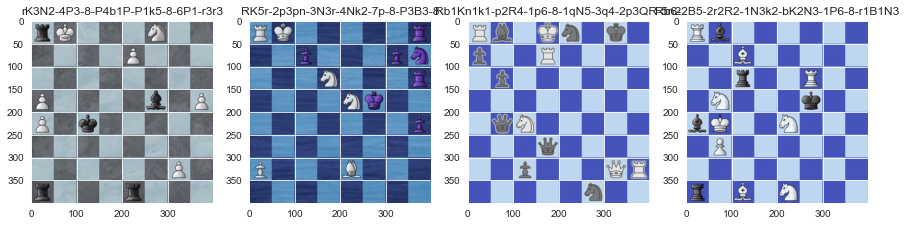

In [539]:
fig, ax = plt.subplots(1,4, figsize=(15,15))
for i in range(4):
    ax[i].set_title(y_train[i])
    ax[i].imshow(X_train[i])

# **Step 4: Preprocessing data**

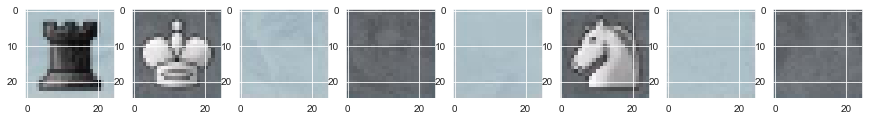

In [540]:
X_test = preprocess(X_test)
X_val = preprocess(X_val)
X_train = preprocess(X_train)

fig, ax = plt.subplots(1,8, figsize=(15,15))
for i in range(8):
    ax[i].imshow(X_train[i])


# **Preprocessing labels**
### label encoder implemetation

In [541]:
le = preprocessing.LabelEncoder()
y_tr = np.array(split_labels(y_train), dtype='str')
y_train_processed = le.fit_transform(y_tr)

print('Encoded classes: ',list(le.classes_))
print('Encoded sample: ',y_train_processed[:7])

save_encoder(le)

y_t = np.array(split_labels(y_test),dtype='str')
y_test_processed = le.transform(y_t)


Encoded classes:  ['1', 'B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r']
Encoded sample:  [12  2  0  0  0  3  0]


In [542]:
encoded_labels = set(y_train_processed)
encoded_labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [543]:
print("Length of training data: ",len(X_train))
print("Length of training labels: ",len(y_train_processed))

Length of training data:  32000
Length of training labels:  32000


y_test: 6


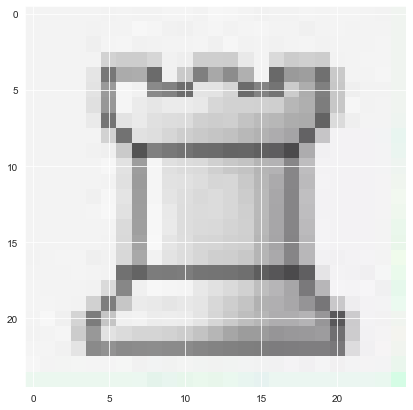

In [544]:
plt.imshow(X_test[0])
print('y_test:',y_test_processed[0])

In [545]:
X_train = (np.array(X_train))
y_train = (np.array(y_train_processed))

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_test = (np.array(X_test))
y_test = (np.array(y_test_processed))

print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (32000, 25, 25, 3)
y_train shape: (32000,)
x_test shape: (12800, 25, 25, 3)
y_test shape: (12800,)


# Visualization of labels


In [546]:
import seaborn as sns


/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

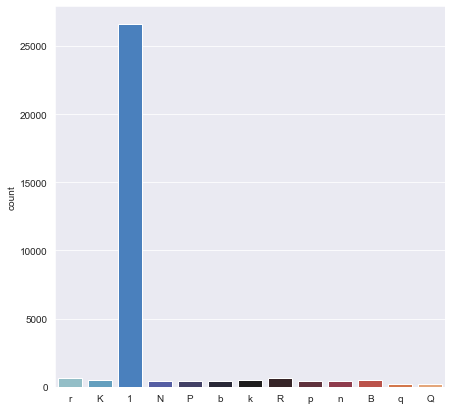

In [547]:
sns.countplot(y_tr, palette = 'icefire')

In [548]:
y_train_df = pd.DataFrame(y_train.reshape(-1,1),columns=['y'])
y_test_df = pd.DataFrame(y_test.reshape(-1,1),columns=['y'])


In [549]:
train_size_x=X_train.shape[0]
train_size_y=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

test_size_x=X_test.shape[0]
test_size_y=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

X_train_pca = np.array([])
X_test_pca = np.array([])

X_train_pca = [img.reshape(train_size_y,1) for img in X_train]
X_test_pca = [img.reshape(train_size_y,1) for img in X_test]

x_train_array = np.array(X_train_pca).reshape((train_size_x,train_size_y))
x_test_array = np.array(X_test_pca).reshape((test_size_x,test_size_y))

df_chess_train = pd.DataFrame(x_train_array)
df_chess_test = pd.DataFrame(x_test_array)



In [550]:
X_train = pd.concat([df_chess_train,y_train_df],axis=1)
X_test = pd.concat([df_chess_test,y_test_df],axis=1)



In [551]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1866,1867,1868,1869,1870,1871,1872,1873,1874,y
0,167,186,193,168,187,194,171,189,196,172,...,185,197,201,185,197,201,186,192,197,12
1,99,110,118,99,107,114,103,106,114,106,...,98,106,115,98,109,117,102,113,121,2
2,174,188,195,164,181,190,163,183,191,167,...,180,195,199,175,191,196,178,194,200,0
3,104,111,120,105,108,116,95,97,105,96,...,100,108,117,97,105,114,89,99,107,0
4,180,193,201,174,192,199,169,189,197,164,...,180,192,195,182,190,195,186,191,198,0


In [552]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,1866,1867,1868,1869,1870,1871,1872,1873,1874,y
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,146.735156,162.665375,175.689844,148.262937,164.184188,177.261344,148.388219,164.270406,177.316469,148.354938,...,149.797281,165.776250,178.848594,149.537937,165.563719,178.536844,148.024281,163.995250,176.874281,1.098531
std,60.049110,53.082140,53.050024,61.359428,54.213222,54.129134,61.359373,54.086345,54.126317,61.679755,...,61.959530,54.277076,54.046578,62.019106,54.586517,54.395604,60.883727,53.718606,53.540148,2.830218
min,7.000000,27.000000,33.000000,13.000000,34.000000,36.000000,18.000000,37.000000,39.000000,15.000000,...,14.000000,36.000000,38.000000,19.000000,38.000000,36.000000,17.000000,25.000000,28.000000,0.000000
25%,102.000000,124.000000,131.000000,97.000000,122.000000,131.000000,96.000000,123.000000,131.000000,97.000000,...,99.000000,124.000000,131.000000,99.000000,123.000000,130.000000,101.000000,125.000000,131.000000,0.000000
50%,147.000000,163.000000,186.000000,154.000000,164.000000,187.000000,154.000000,163.000000,186.000000,154.000000,...,155.000000,164.000000,188.000000,155.000000,163.000000,189.000000,149.000000,163.000000,187.000000,0.000000
75%,190.000000,213.000000,217.000000,190.000000,215.000000,221.000000,189.000000,215.000000,221.000000,190.000000,...,203.000000,216.000000,222.000000,202.000000,217.000000,222.000000,198.000000,215.000000,220.000000,0.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,12.000000


In [553]:
X_train['y'].value_counts()


0     26581
6       666
12      644
2       500
8       500
1       481
4       455
3       449
10      445
7       441
9       438
11      217
5       183
Name: y, dtype: int64

<AxesSubplot:>

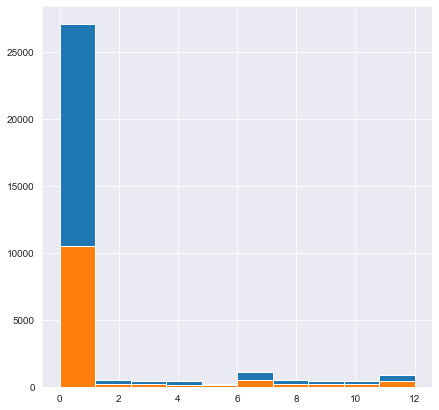

In [554]:
X_train['y'].hist()
X_test['y'].hist()

# Step 4: Solving data Imbalance using resampling

Chess board contains more blank cells compared to the occupied ones. so there will always be data imbalance problem


In [555]:

train_count = resample(X_train,40)
test_count = resample(X_test,40)

print('train_count',train_count,'test_count',test_count)

# labels = [0.0]
for i in encoded_labels:
    # print(i)
    X_train = remove_values(i,train_count,X_train)
    X_test = remove_values(i,test_count,X_test)

train_count 183 test_count 105


## Visualisation of balanced data

/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='count'>

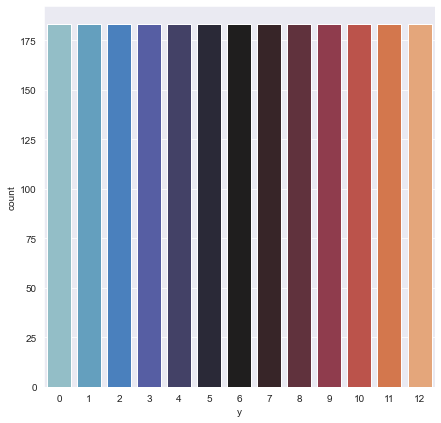

In [556]:
sns.countplot(X_train['y'], palette = 'icefire')

/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='count'>

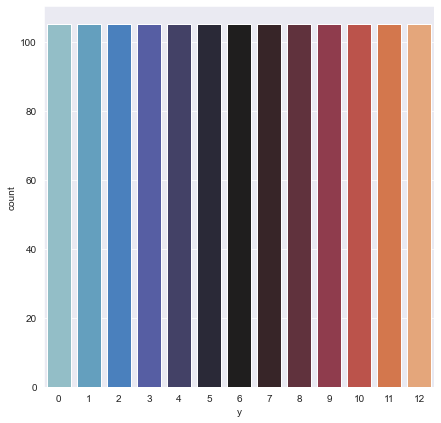

In [557]:
sns.countplot(X_test['y'], palette = 'icefire')

## Step 5: Split Dataset

In [558]:
train_y = X_train['y']
train_X = X_train.drop(columns=['y'])

test_y = X_test['y']
test_X = X_test.drop(columns=['y'])



In [559]:
train_X.shape

(2379, 1875)

# Step 6: Normalization

In [560]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True).fit(train_X)
X_train_norm = scaler.transform(train_X)
X_test_norm = scaler.transform(test_X)

In [561]:
X_train_norm.std(), X_test_norm.std()

(0.9999999999999998, 0.9886432446242495)

In [562]:
X_train_pca = X_train_norm
y_train_pca = train_y
X_test_pca = X_test_norm
y_test_pca = test_y


# Visualization using TSNE

In [563]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train_pca)

/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2379 samples in 0.009s...
[t-SNE] Computed neighbors for 2379 samples in 3.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2379
[t-SNE] Computed conditional probabilities for sample 2000 / 2379
[t-SNE] Computed conditional probabilities for sample 2379 / 2379
[t-SNE] Mean sigma: 13.202692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.473892
[t-SNE] KL divergence after 300 iterations: 1.301149


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

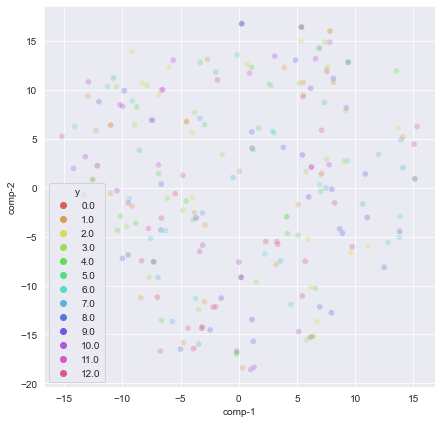

In [564]:
plt.rcParams["figure.figsize"] = (7,7)
tsne_df = pd.DataFrame()

tsne_df["comp-1"] = tsne_results[:,0]
tsne_df["comp-2"] = tsne_results[:,1]

sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=train_y, palette=sns.color_palette("hls", 13), data=tsne_df,
    legend="full", alpha=0.3
)

# **Step 7: Finding the principle components**

In [565]:
from sklearn.decomposition import PCA
dim_sel = PCA()
df_PCA = dim_sel.fit_transform(X_train_pca)
dim_sel.n_components_

1875

In [566]:
df_PCA.shape

(2379, 1875)

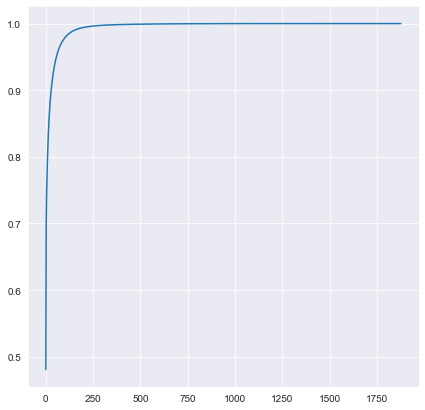

In [567]:
plt.plot(range(1,dim_sel.n_components_+1), dim_sel.explained_variance_ratio_.cumsum());


# Step 8: Modeling pipeline for prediction

In [568]:
pca = None
svc = None
scaler = None

def pipeline_processing(X_train_, X_test_, y_train_, y_test_, is_train, model=None):
    """
This defines the pipeline for model prediction
    :param X_train_: train dataset
    :param X_test_: test dataset
    :param y_train_: train labels
    :param y_test_: test labels
    :param is_train: flag to check if training or inference
    :param model: trained model
    :return: predicted labels,accuracy, and model if it is training phase
    """
    scaler = StandardScaler(with_mean=True, with_std=True)
    pca = PCA(n_components=150)
    svc = SVC(kernel='rbf', degree=2, decision_function_shape='ovo')
    pipeline = Pipeline([
                         ('scale', scaler),
                         ('pca', pca),
                         ('svm', svc),
    ])

    if is_train:
        pipeline.fit(X_train_, y_train_)
        y_test_pred = pipeline.predict(X_test_)
        acc = accuracy_score(y_test_, y_test_pred)
        save_model(pipeline) # save model in memory for inference
        return y_test_pred, acc, pipeline
    else:
        y_test_pred = model.predict(X_test_)
        return y_test_pred, -1, model

# Step 9: Accuracy score

### Testing model predictions with training set


In [574]:
y_pred_pipe, accuracy_pipe, model = pipeline_processing(train_X, test_X, train_y,test_y , True)
print("Training accuracy : ",accuracy_pipe)

Trainig accuracy :  0.9663003663003663


### Testing model predictions with test set


In [570]:
y_pred_pipe, accuracy_pipe , model= pipeline_processing([], test_X, [],test_y , False, model)
print("Testing accuracy : ",accuracy_score(y_test_pca, y_pred_pipe))

0.9663003663003663

# **SVM for prediction of fen**

In [571]:

def process_test_img(chess_board_image):
    test_image_ = [img.reshape(1875,1) for img in chess_board_image]
    test_image_ = (np.array(test_image_))

    size_x=test_image_.shape[0]
    size_y=test_image_.shape[1]*test_image_.shape[2]

    test_board_img = [img.reshape(size_y,1) for img in test_image_]
    test_board_array = np.array(test_board_img).reshape((size_x,size_y))
    processed_test_img = pd.DataFrame(test_board_array)

    return processed_test_img


def predict(chess_board_image):
    processed_test_img = process_test_img(chess_board_image)
    model = load_model('models/pipeline_model.pkl')
    prediction = model.predict(processed_test_img)
    fen_predicted = decode_fen(np.array(prediction).reshape(8,8))
    return fen_predicted



# Step 10: Making prediction

In [572]:
random_index = randint(0,len(val))
test_image,test_img_orginal = prepare_test_image(val[random_index])
prediction  = predict(test_image)
prediction

'R7-8-3p2k1-2QK4-8-8-8-7n'

# Comparison with original chess board

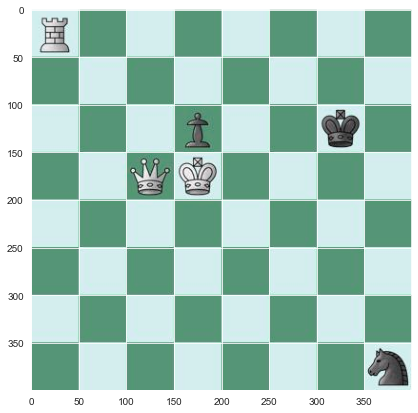

In [573]:
plt.imshow(test_img_orginal)